### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *

### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


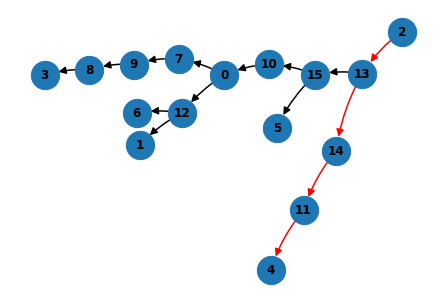

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

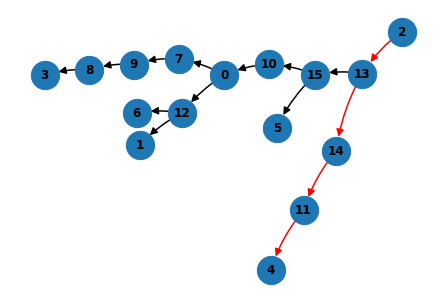

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 64)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 8>3,2>6,8>7,15>13,13>9,13>1,6>0,14>2,8>10,8>14,1>5,0>11,10>12,4>15,5>8|9:4
Completion: >15>13>9

Prompt: 5>8,9>7,9>14,8>1,7>2,4>5,10>11,6>10,9>15,15>6,0>13,9>3,12>0,4>12,14>4|13:9
Completion: >14>4>12>0>13

Prompt: 2>14,8>2,5>10,8>6,5>8,10>11,5>13,5>4,9>3,10>15,9>1,6>9,0>5,3>12,14>7|1:0
Completion: >5>8>6>9>1

Prompt: 15>6,9>11,13>8,12>7,13>4,4>10,1>2,4>9,4>12,9>0,4>15,8>14,1>5,15>1,10>3|2:13
Completion: >4>15>1>2

Prompt: 0>7,14>1,10>8,4>13,13>11,9>4,13>15,6>0,4>14,7>12,7>9,0>3,9>5,14>2,9>10|11:6
Completion: >0>7>9>4>13>11

Prompt: 8>12,5>4,2>1,1>11,15>8,15>13,10>9,4>15,10>3,10>0,0>7,7>14,3>2,8>10,12>6|14:5
Completion: >4>15>8>10>0>7>14

Prompt: 9>7,13>5,13>1,4>11,8>2,0>9,10>15,8>13,13>12,0>6,5>0,8>3,10>8,5>14,6>4|1:10
Completion: >8>13>1

Prompt: 1>11,12>15,9>10,8>14,4>6,6>9,2>4,14>13,3>1,4>5,3>7,11>8,11>0,11>12,1>2|5:3
Completion: >1>2>4>5

Prompt: 9>4,4>15,14>5,3>9,7>2,13>14,12>7,5>1,4>8,0>11,7>0,9>13,13>10,3>12,7>6|2:3
Completion: >12>7>2

Prompt: 6>1,2>4,5>2,9>15,3>14,2>9

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [6]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

TRAIN - Epoch: 1, Loss: 0.9282, Acc: 73.6658%:   5%|▍         | 118/2419 [00:03<01:11, 32.01it/s]

### Experiment 1: Attention Visualization + Masking

### Experiment 2: Activation Patching